In [ ]:
from transformers import CLIPModel, CLIPProcessor, AutoTokenizer, AutoModelForCausalLM
import torch
import json
from huggingface_hub import hf_hub_download
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from scripts.load_model import load_projector

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
projector = load_projector()

config.json:   0%|          | 0.00/46.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

/tmp/ipykernel_71/1709463027.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device))


In [4]:
clip_name = "openai/clip-vit-base-patch32"
llm_name = "Qwen/Qwen2.5-1.5B-Instruct"

clip_model = CLIPModel.from_pretrained(clip_name).eval().to(device)
clip_processor = CLIPProcessor.from_pretrained(clip_name)

llm = AutoModelForCausalLM.from_pretrained(llm_name, device_map="auto").eval().to(device)
tokenizer = AutoTokenizer.from_pretrained(llm_name)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:
system_prompt = "You are an expert interior designer assistant. Your task is to suggest suitable decor based on the inner design of a room described in a caption. The caption may include details about the room's layout, furniture, lighting, materials, colors, and style. Based on this information, provide thoughtful and visually harmonious decor suggestions that enhance the room's existing features. Be creative but practical, ensuring your suggestions match the overall theme and feel of the space."

user_prompt = (
    "Based on this image, suggest appropriate decoration items that would fit the space. "
    "Only output the suggestion — do not include any introductions, explanations, or extra text.\n\n"
    "Room image provided below.\n"
    "Decoration suggestion:"
)

In [11]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [12]:
def compute_clip_embedding(images):
    inputs = clip_processor(images=images, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        img_feats = clip_model.get_image_features(**inputs)  # [n, 512]
    return img_feats.mean(dim=0)  # [512]

def predict(image, system_prompt=system_prompt, user_prompt_template=user_prompt):
    image = preprocess(image)
    image_embedding = compute_clip_embedding(image)
    projected = projector(image_embedding)
    user_prompt = user_prompt_template.format(caption="<fill>")
    messages = [
        {
            "role": "system",
            "content": system_prompt
        },
        {
            "role": "user",
            "content": user_prompt
        }
    ]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False)
    tokenized = tokenizer(prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        embeddings = llm.model.embed_tokens(tokenized.input_ids)
        
    full_input = torch.cat([projected, embeddings], dim=1)
    
    output_ids = llm.generate(
        inputs_embeds=full_input,
        max_new_tokens=500,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return output

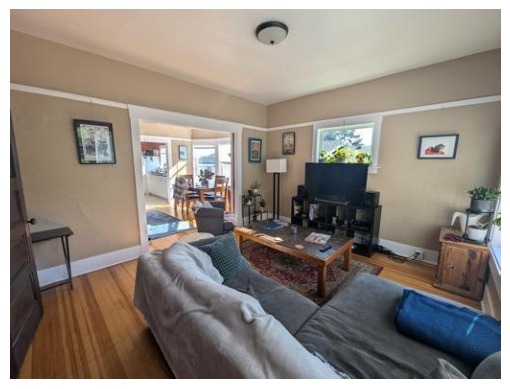

In [13]:
image_path = "/kaggle/input/sample-image/photo_2025-05-05_11-35-13.jpg"
image = Image.open(image_path)
plt.axis("off")
plt.imshow(image)
plt.show()

In [17]:
print(predict(image))

system
A comfortable and cozy throw blanket with a soft texture, paired with plush cushions in matching colors to add warmth and comfort to the space.
